# Replication of COCKATIEL

## Original Study's Code

### Prepare RoBERTa Model

In [1]:
import torch
from torch import nn
from torch.nn import MSELoss
from transformers import RobertaPreTrainedModel, RobertaModel



# A custom fully-connected classification head for RoBERTa with a non-negative layer on which we can compute the NMF.

class CustomRobertaClassificationHead(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(config.hidden_size, 2)

    def forward(self, features):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x) # Projection layer, yani multi-head attention katmanının yüksek boyutlu output'unu düşürmek için project yapar
                             # Ardından final sınıflandırma logits'leri hesaplanır
        return x

    # out_proj olmadan feature'ları hesaplayan fonk.
    def features(self, x):
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        return x

    # forward()'ın sonunda yapılan işlemin aynısı, ayrı fonk. olarak da tanımlamışlar
    def end_model(self, x):
        x = self.dropout(x)
        x = self.out_proj(x)

        return x
    

    
    
    
# A custom RoBERTa model using a custom fully-connected head with a non-negative layer on which we can compute the NMF.
    
class CustomRobertaForSequenceClassification(RobertaPreTrainedModel):

    # Model yüklenirken position_ids'i ignore etsin
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        
        # Regresyon problemi gibi ele aldıklarından 1 demişler, yoksa sentiment a. için 2 olmalıydı
        self.num_labels = 1
        self.config = config

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = CustomRobertaClassificationHead(config)
        
        # Yine regresyon olmasından dolayı
        self.mse_loss = MSELoss()

        # Modelin başka hiperparametrelerini initialize etmek için ek fonk.
        self.post_init()

    def features(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        features = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        return self.classifier.features(features[0][:, 0, :])

    def end_model(self, activations):
        return self.classifier.end_model(activations)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0][:, 0, :]
        logits = self.classifier(sequence_output)

        return logits

### COCKATIEL

In [2]:
import numpy as np
import torch
from sklearn.decomposition import NMF
from math import ceil
from typing import Callable, List


class COCKATIEL:
    """
    model
        The Torch hugging-face model that we wish to explain. It MUST have a non-negative layer on
        which to extract the concepts.
    tokenizer
        A callable object to transform strings into inputs for the model.
    components
        An integer for the amount of concepts we wish to discover in the activation space.
    batch_size
        The batch size for all the operations that use the model
    device
        The type of device on which to place the torch tensors
    """
    sobol_nb_design = 32

    def __init__(
            self,
            model,
            tokenizer: Callable,
            components: int = 25,
            batch_size: int = 256,
            device: str = 'cuda',
            nmf_max_iter: int = 1000
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.components = components
        self.batch_size = batch_size
        self.device = device
        self.max_iter = nmf_max_iter

    def extract_concepts(
            self,
            cropped_dataset: List[str],
            dataset: List[str],
            class_id: int,
            limit_sobol: int = 1000
    ):
        """
        Extracts the concepts following the object's parameters.

        Parameters
        ----------
        cropped_dataset
            The dataset containing the excerpts used to discover the concepts.
        dataset
            A sample of the dataset (with whole inputs) on which to compute the Sobol importance.
        class_id
            An integer for the class we wish to explain.
        limit_sobol
            The maximum amount of masks to use for estimating Sobol indices.

        Returns
        -------
        excerpts
            The excerpts used to learn the concepts.
        u_excerpts
            The coefficients in the learned concept base for the excerpts.
        factorization
            The object to transform activations using the concept base.
        global_importance
            An array with the global importance of each concept (Sobol indices).
        """
        excerpts = []
        excerpts_activations = None

        with torch.no_grad():
            for batch_id in tqdm(range(ceil(len(cropped_dataset) / self.batch_size))):
                
                batch_start = batch_id * self.batch_size
                batch_end = batch_start + self.batch_size

                batch_sentences = cropped_dataset[batch_start:batch_end]
                batch_tokenized = tokenize(batch_sentences, self.tokenizer, self.device)

                batch_activations = self.model.features(**batch_tokenized)

                excerpts_activations = batch_activations if excerpts_activations is None \
                    else torch.cat([excerpts_activations, batch_activations], 0)
                excerpts = batch_sentences if excerpts is None \
                    else excerpts + batch_sentences

        points_activations = None
        with torch.no_grad():
            for batch_id in tqdm(range(ceil(len(dataset) / self.batch_size))):
                
                batch_start = batch_id * self.batch_size
                batch_end = batch_start + self.batch_size
                
                tokenized_batch = tokenize(dataset[batch_start:batch_end], self.tokenizer, self.device)
                activations = self.model.features(**tokenized_batch)
                points_activations = activations if points_activations is None else torch.cat(
                    [points_activations, activations])

        # applying GAP(.) on the activation and ensure positivity if needed
        excerpts_activations = self._preprocess(excerpts_activations)
        points_activations = self._preprocess(points_activations)

        # using the activations, we will now use the matrix factorization to
        # find the concept bank (W) and the concept representation (U) of the
        # segments and the points
        factorization = NMF(n_components=self.components, max_iter=self.max_iter)

        u_excerpts = factorization.fit_transform(excerpts_activations)
        W = torch.Tensor(factorization.components_).float().to(self.device)

        # we don't need segments activations anymore, the concept bank is trained
        del excerpts_activations

        # using the concept bank and the points, we will now evaluate the importance of
        # each concept for each points to get a global importance score for each
        # concept in the concept bank
        global_importance = self._sobol_importance(cropped_dataset, points_activations[:limit_sobol], class_id, W)

        return excerpts, u_excerpts, factorization, global_importance

    def _sobol_importance(self, cropped_dataset, activations: torch.Tensor, class_id: int, W: torch.Tensor):
        """
        Computes the Sobol indices using the dataset containing the excerpts and the activations from the
        dataset (whole inputs) for the target class, and for a fixed (already learned) concept base W.

        Parameters
        ----------
        cropped_dataset
            The activations of the dataset containing the excerpts used to discover the concepts.
        activations
            The activations for inputs from the original dataset.
        class_id
            An integer for the class we wish to explain.
        W
            The (already learned) concept base.

        Returns
        -------
        global_importance
            An array with the Sobol indices
        """
        masks = ScipySobolSequence()(self.components, nb_design=self.sobol_nb_design)
        estimator = JansenEstimator()

        if not isinstance(W, torch.Tensor):
            W = torch.Tensor(W).float().to(self.device)

        importances = []
        for act in activations:
            act = torch.Tensor(act).float().to(self.device)

            y_pred = None
            for batch_id in range(ceil(len(cropped_dataset) / self.batch_size)):
                batch_start = batch_id * self.batch_size
                batch_end = batch_start + self.batch_size
                batch_masks = torch.Tensor(masks[batch_start:batch_end]).float().to(self.device)

                y_batch = concept_perturbation(self.model, act, batch_masks, class_id, W)
                y_pred = y_batch if y_pred is None else torch.cat([y_pred, y_batch], 0)

            if self.device == 'cuda' or self.device == torch.device('cuda'):
                y_pred = y_pred.cpu()
            stis = estimator(masks, y_pred.numpy(), self.sobol_nb_design)
            importances.append(stis)

        global_importance = np.mean(importances, 0)

        return global_importance

    def _preprocess(self, activations: torch.Tensor):
        """
        Preprocesses the activations to make sure that they're the right shape for being input to the
        NMF algorithm later.

        Parameters
        ----------
        activations
            The (non-negative) activations from the model under study.

        Returns
        -------
        activations
            The preprocessed activations, ready for COCKATIEL.
        """
        if len(activations.shape) == 4:
            activations = torch.mean(activations, (1, 2))

        if torch.min(activations) < 0:
            raise ValueError("Please choose a layer with positive activations.")
        if self.device == 'cuda' or self.device == torch.device('cuda'):
            activations = activations.cpu()

        return activations.numpy().astype(np.float32)

### Occlusion

In [3]:
import numpy as np
import sklearn.decomposition
from typing import List, Callable, Optional, Union, Tuple
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


"""
This module implements the local part of COCKATIEL: occlusion. This allows us to estimate the presence of
concepts in parts of the input text.
"""

def occlusion_concepts(
        sentence: str,
        model,
        tokenizer: Callable,
        factorization: Union[sklearn.decomposition.NMF, Tuple[sklearn.decomposition.NMF, sklearn.decomposition.NMF]],
        l_concept_id: Union[np.ndarray, Tuple[np.ndarray, np.ndarray]],
        ignore_words: Optional[List[str]] = None,
        two_labels: bool = True,
        extract_fct: str = "clause",
        device='cuda'
) -> np.ndarray:
    """
    Generates explanations for the input sentence using COCKATIEL.

    If two_labels is False, it computes the presence of the concepts of interest (in l_concept_id) using the
    NMF object in factorization.
    If two_labels is True, it computes the presence of the concepts of interest in the tuple of l_concept_id using
    the tuple of NMF objects in factorization (to do so for both classes in imdb-reviews task).

    The granularity of the explanations is set with extract_fct.

    Parameters
    ----------
    sentence
        The string (sentence) we wish to explain using COCKATIEL.
    model
        The model under study.
    tokenizer
        A Callable that transforms strings into tokens capable of being ingested by the model.
    factorization
        Either the NMF object to transform activations into the concept base, or a tuple with an object for each of
        the two classes (for the imdb-reviews task) if two_labels is True.
    l_concept_id
        Either a list of concepts of interest (for a given task) or a tuple with two lists, one for each class (if
        two_labels is True).
    ignore_words
        A list of strings to ignore when applying occlusion.
    two_labels
        A bool indicating whether we wish to explain only one class or both (for imdb-reviews task).
    extract_fct
        A string indicating whether at which level we wish to explain: "word", "clause" or "sentence".
    device
        The device on which tensors are stored ("cpu" or "cuda").

    Returns
    -------
    l_importances
        An array with the presence of each concept in the input sentence.
    """
    sentence = str(sentence)

    if extract_fct == "clause":
        words = extract_clauses(sentence, clause_type=None)
        separate = " "

    else:
        words = word_tokenize(sentence)
        if extract_fct == "sentence":
            separate = ". "
        elif extract_fct == "word":
            separate = " "
        else:
            raise ValueError("Extraction function can be only 'clause', 'sentence', or 'word")

    if two_labels:
        u_values_pos = calculate_u_values(sentence, words,  model, tokenizer, factorization[0], separate, ignore_words, device)
        u_values_neg = calculate_u_values(sentence, words,  model, tokenizer, factorization[1], separate, ignore_words, device)
        l_importances = []
        for concept_id in l_concept_id[0]:
            importances = calculate_importance(words, u_values_pos, concept_id, ignore_words)
            l_importances.append(np.array(importances))
        for concept_id in l_concept_id[1]:
            importances = calculate_importance(words, u_values_neg, concept_id, ignore_words)
            l_importances.append(np.array(importances))

    else:  # look at only one class:
        u_values = calculate_u_values(sentence, words,  model, tokenizer, factorization, separate, ignore_words, device)
        l_importances = []
        for concept_id in l_concept_id:
            importances = calculate_importance(words, u_values, concept_id, ignore_words)
            l_importances.append(np.array(importances))

    return np.array(l_importances)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Sampling

In [4]:
from abc import ABC, abstractmethod
import numpy as np
import scipy


"""
Sampling methods for replicated designs
"""

class Sampler(ABC):
    """
    Base class for replicated design sampling.
    """

    @staticmethod
    def build_replicated_design(sampling_a, sampling_b):
        """
        Build the replicated design matrix C using A & B

        Parameters
        ----------
        sampling_a
          The masks values for the sampling matrix A.
        sampling_b
          The masks values for the sampling matrix B.

        Returns
        -------
        replication_c
          The new replicated design matrix C generated from A & B.
        """
        replication_c = np.array([sampling_a.copy() for _ in range(sampling_a.shape[-1])])
        for i in range(len(replication_c)):
            replication_c[i, :, i] = sampling_b[:, i]

        replication_c = replication_c.reshape((-1, sampling_a.shape[-1]))

        return replication_c

    @abstractmethod
    def __call__(self, dimension, nb_design):
        raise NotImplementedError()


class ScipySampler(Sampler):
    """
    Base class based on Scipy qmc module for replicated design sampling.
    """

    def __init__(self):
        try:
            self.qmc = scipy.stats.qmc
        except AttributeError as err:
            raise ModuleNotFoundError("COCKATIEL need scipy>=1.7 to use this sampling.") from err


class ScipySobolSequence(ScipySampler):
    """
    Scipy Sobol LP tau sequence sampler.

    Ref. I. M. Sobol., The distribution of points in a cube and the accurate evaluation of
    integrals (1967).
    https://www.sciencedirect.com/science/article/abs/pii/0041555367901449
    """

    def __call__(self, dimension, nb_design):
        sampler = self.qmc.Sobol(dimension * 2, scramble=False)
        sampling_ab = sampler.random(nb_design).astype(np.float32)
        sampling_a, sampling_b = sampling_ab[:, :dimension], sampling_ab[:, dimension:]
        replicated_c = self.build_replicated_design(sampling_a, sampling_b)

        return np.concatenate([sampling_a, sampling_b, replicated_c], 0)


def concept_perturbation(model, activation, masks, class_id, W):
    """
    Apply perturbation on the concept before reconstruction and get the perturbated outputs.
    For NMF we recall that A = U @ W

    Parameters
    ----------
    model
      Model that map the concept layer to the output (h_l->k in the paper)
    activation
      Specific activation to apply perturbation on.
    masks
      Arrays of masks, each of them being a concept perturbation.
    class_id
      Id the class to test.
    W
      Concept bank extracted using NMF.

    Returns
    -------
    y
      Outputs of the perturbated points.
    """
    perturbation = masks @ W

    if len(activation.shape) == 3:
        perturbation = perturbation[:, None, None, :]

    activation = activation[None, :]
    perturbated_activations = activation + perturbation * activation
    y = model.end_model(perturbated_activations)[:, class_id]

    return y

### Total Sobol Indices

In [5]:
from abc import ABC, abstractmethod
import numpy as np



"""
Sobol' total order estimators module
"""

class SobolEstimator(ABC):
    """
    Base class for Sobol' total order estimators.
    """

    @staticmethod
    def masks_dim(masks):
        """
        Deduce the number of dimensions using the sampling masks.

        Parameters
        ----------
        masks
          Low resolution masks (before upsampling) used, one for each output.

        Returns
        -------
        nb_dim
          The number of dimensions under study according to the masks.
        """
        nb_dim = np.prod(masks.shape[1:])
        return nb_dim

    @staticmethod
    def split_abc(outputs, nb_design, nb_dim):
        """
        Split the outputs values into the 3 sampling matrices A, B and C.

        Parameters
        ----------
        outputs
          Model outputs for each sample point of matrices A, B and C (in order).
        nb_design
          Number of points for matrices A (the same as B).
        nb_dim
          Number of dimensions to estimate.

        Returns
        -------
        a
          The results for the sample points in matrix A.
        b
          The results for the sample points in matrix B.
        c
          The results for the sample points in matrix C.
        """
        sampling_a = outputs[:nb_design]
        sampling_b = outputs[nb_design:nb_design*2]
        replication_c = np.array([outputs[nb_design*2 + nb_design*i:nb_design*2 + nb_design*(i+1)]
                      for i in range(nb_dim)])
        return sampling_a, sampling_b, replication_c

    @staticmethod
    def post_process(stis, masks):
        """
        Post processing ops on the indices before sending them back. Makes sure the data
        format and shape is correct.

        Parameters
        ----------
        stis
          Total order Sobol' indices, one for each dimensions.
        masks
            Low resolution masks (before upsampling) used, one for each output.

        Returns
        -------
        stis
          Total order Sobol' indices after post processing.
        """
        stis = np.array(stis, np.float32)
        return stis.reshape(masks.shape[1:])

    @abstractmethod
    def __call__(self, masks, outputs, nb_design):
        """
        Compute the Sobol' total order indices according to the Jansen algorithm.

        Ref. Jansen, M., Analysis of variance designs for model output (1999)
        https://www.sciencedirect.com/science/article/abs/pii/S0010465598001544

        Parameters
        ----------
        masks
          Low resolution masks (before upsampling) used, one for each output.
        outputs
          Model outputs associated to each masks. One for each sample point of
          matrices A, B and C (in order).
        nb_design
          Number of points for matrices A (the same as B).

        Returns
        -------
        sti: ndarray
          Total order Sobol' indices, one for each dimensions.
        """
        raise NotImplementedError()


class JansenEstimator(SobolEstimator):
    """
    Jansen estimator for total order Sobol' indices.

    Ref. Jansen, M., Analysis of variance designs for model output (1999)
    https://www.sciencedirect.com/science/article/abs/pii/S0010465598001544
    """

    def __call__(self, masks, outputs, nb_design):
        """
        Compute the Sobol' total order indices according to the Jansen algorithm.

        Parameters
        ----------
        masks
          Low resolution masks (before upsampling) used, one for each output.
        outputs
          Model outputs associated to each masks. One for each sample point of
          matrices A, B and C (in order).
        nb_design
          Number of points for matrices A (the same as B).

        Returns
        -------
        sti
          Total order Sobol' indices, one for each dimensions.
        """
        nb_dim = self.masks_dim(masks)
        sampling_a, _, replication_c = self.split_abc(outputs, nb_design, nb_dim)

        mu_a = np.mean(sampling_a)
        var = np.sum([(v - mu_a)**2 for v in sampling_a]) / (len(sampling_a) - 1)

        stis = [
            np.sum((sampling_a - replication_c[i])**2.0) / (2 * nb_design * var)
            for i in range(nb_dim)
        ]

        return self.post_process(stis, masks)
    

### Util Functions

In [6]:
import torch
from math import ceil
import numpy as np
from flair.models import SequenceTagger
from flair.data import Sentence
from typing import List, Callable, Union, Optional, Tuple

# load tagger
tagger = SequenceTagger.load("flair/chunk-english")



def batcher(elements, batch_size: int):
    """
    An iterable to create batches from a list of elements
    """
    nb_batchs = ceil(len(elements) / batch_size)

    for batch_i in range(nb_batchs):
        batch_start = batch_i * batch_size
        batch_end = batch_start + batch_size

        batch = elements[batch_start:batch_end]
        yield batch
        
        
def tokenize(samples: List[str], tokenizer: Callable, device='cuda'):
    """
    A function to transform a list of strings into tokens to be consumed by the transformer model.
    """
    x = tokenizer(
        [s for s in samples],
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    return x


def preprocess(samples: List[Tuple[str, str]], tokenizer: Callable, device='cuda'):
    """
    A basic pre-processing function to transform the format from the imdb dataset to
    something easier to work with.
    """
    x, y = samples[:, 0], samples[:, 1]
    x = tokenize(x, tokenizer, device)
    y = torch.Tensor(y == 'positive').int().to(device)
    return x, y


def batch_predict(model, tokenizer: Callable, inputs: List[Tuple[str, str]], batch_size: int = 64, device='cuda'):
    """
    A function to pre-process and predict using the transformer model in batches.
    """
    predictions = None
    labels = None

    with torch.no_grad():
        for batch_input in batcher(inputs, batch_size):
            xp, yp = preprocess(batch_input, tokenizer, device)
            out_batch = model(**xp)
            predictions = out_batch if predictions is None else torch.cat([predictions, out_batch])
            labels = yp if labels is None else torch.cat([labels, yp])

        return predictions, labels
    
    
    
def extract_clauses(ds_entry: Union[List[str], str], clause_type=['NP', 'ADJP']) -> List[str]:
    """
    Separates the input texts into clauses, and only keeps the ones belonging to the specified types.
    If clause_type is None, the texts are split but all the clauses are kept.

    Parameters
    ----------
    ds_entry
        A list of strings that we wish to separate into clauses.
    clause_type
        A list with the types of clauses to keep. If None, all clauses are kept.

    Returns
    -------
    clause_list
        A list with input texts split into clauses.
    """
    s = Sentence(ds_entry)
    tagger.predict(s)
    clause_list = []
    for segment in s.get_labels():
        if clause_type is None:
            clause_list.append(segment.data_point.text)
        elif segment.value in clause_type:
            clause_list.append(segment.data_point.text)

    return clause_list



def batch_activations_fct(model, inputs: List[str], batch_size=64) -> torch.Tensor:
    """
    A function to extract the activations of input texts in batches.
    """
    activations = None
    with torch.no_grad():
        for batch_input in batcher(inputs, batch_size):
            out_batch = model.features(**batch_input)
            activations = out_batch if activations is None else torch.cat([activations, out_batch])
        return activations
    
    

def acti_preprocess(activations: torch.Tensor) -> np.ndarray:
    """
    A function to preprocess the activations to work with COCKATIEL
    """
    if len(activations.shape) == 4:
        activations = torch.mean(activations, (1, 2))

    if isinstance(activations, np.ndarray):
        activations = torch.Tensor(activations)
    if torch.min(activations) < 0:
        raise ValueError("Please choose a layer with positive activations.")

    return activations.cpu().numpy().astype(np.float32)



def calculate_u_values(sentence, cropped_sentences, model, tokenizer, factorization,
                       separate, ignore_words: Optional[List[str]] = None, device='cuda') -> np.ndarray:
    if ignore_words is None:
        ignore_words = []
    with torch.no_grad():
        activations = None
        for crop_id in range(-1, len(cropped_sentences)):
            if crop_id == -1:
                perturbated_review = sentence
            elif cropped_sentences[crop_id] not in ignore_words:
                perturbated_review = separate.join(np.delete(cropped_sentences, crop_id))
            else:
                continue
            tokenized_perturbated_review = tokenizer(perturbated_review, truncation=True, padding=True, return_tensors="pt").to(device)
            activation = model.features(**tokenized_perturbated_review)
            activations = activation if activations is None else torch.cat([activations, activation])

        activations = acti_preprocess(activations)
        u_values = factorization.transform(activations)
        
        return u_values
    

    
def calculate_importance(
        words: List[str], u_values: np.ndarray, concept_id: int, ignore_words: List[str]
) -> List[float]:
    """
    Calculates the presence of concepts in the input list of words.
    """
    u_delta = u_values[0, concept_id] - u_values[1:, concept_id]
    importances = []
    delta_id = 0  # pointer to get current id in importance (as we skip unused word)

    for word_id in range(len(words)):
        if words[word_id] not in ignore_words:
            importances.append(u_delta[delta_id])
            delta_id += 1
        else:
            importances.append(0.0)

    return importances



def extract_excerpts(raw_dataset, n_reviews_for_excerpts):
    
    sentence_separators = ['.', '...', '?', '!', '..']
    excerpt_dataset = []
    
    for review in raw_dataset[:n_reviews_for_excerpts]:
        review = str(review)
        
        for sep in sentence_separators:
            review = review.replace(sep, '.')
  
        cropped_review = review.split('.')
    
        for crop in cropped_review:
            
            if len(crop):
                crop = crop + '.'
                
                while crop[0] == ' ':
                    crop = crop[1:]
      
                if crop[0].isupper():  
                    excerpt_dataset.append(crop)
                
    return excerpt_dataset

2023-11-10 14:57:12,873 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


### Visualization

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from typing import List, Optional
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
plt.style.use('seaborn')



"""
A module for generating plots for the explanations on notebooks.
"""

def print_legend(colors, label_to_criterion):
    """
    Prints the legend for the plot in different colors.

    Parameters
    ----------
    colors
        A dictionary with the colors for each label.
    label_to_criterion
        A dictionary with the text to put on each label.
    """
    html = []
    for label_id in label_to_criterion.keys():
        html.append(f'<span style="background-color: {colors[label_id]} 0.5); padding: 1px 5px; border: solid 3px ; border-color: {colors[label_id]} 1); #EFEFEF">{label_to_criterion[label_id]} </span>')
    display(HTML("<div style='display: flex; width: 400px; flex-wrap: wrap'>" +  " ".join(html) + " </div>" ))
    display(HTML('<br><br>'))


def viz_concepts(
        text,
        explanation,
        colors,
        ignore_words: Optional[List[str]] = None,
        extract_fct: str = "clause"
):
    """
    Generates the visualization for COCKATIEL's explanations.

    Parameters
    ----------
    text
        A string with the text we wish to explain.
    explanation
        An array that corresponds to the output of the occlusion function.
    ignore_words
        A list of strings to ignore when applying occlusion.
    extract_fct
        A string indicating whether at which level we wish to explain: "word", "clause" or "sentence".
    colors
        A dictionary with the colors for each label
    """
    try:
        text = text.decode('utf-8')
    except:
        text = str(text)

    if extract_fct == "clause":
        words = extract_clauses(text, clause_type=None)
    else:
        words = word_tokenize(text)

    l_phi = np.array(explanation)

    phi_html = []

    p = 0  # pointer to get current color for the words (it does not color words that have no phi)
    for i in range(len(words)):
        if words[i] not in ignore_words:
            k = 0
            for j in range(len(l_phi)):
                if l_phi[k][p] < l_phi[j][p]:
                    k = j

            if l_phi[k][p] > 0.2:
                phi_html.append(f'<span style="background-color: {colors[k]} {l_phi[k][p]}); padding: 1px 5px; border: solid 3px ; border-color: {colors[k]} 1); #EFEFEF">{words[i]}</span>')
                p += 1
            else:
                phi_html.append(f'<span style="background-color: rgba(233,30,99,0);  padding: 1px 5px; border: solid 3px ; border-color:  rgba(233,30,99,0); #EFEFEF">{words[i]}</span>')
                p += 1
        else:
            phi_html.append(f'<span style="background-color: rgba(233,30,99,0);  padding: 1px 5px; border: solid 3px ; border-color:  rgba(233,30,99,0); #EFEFEF">{words[i]}</span>')
    display(HTML("<div style='display: flex; width: 400px; flex-wrap: wrap'>" +  " ".join(phi_html) + " </div>" ))
    display(HTML('<br><br>'))
    
    

def plot_glob_importances(global_importance_pos, global_importance_neg):

#     plt.figure(figsize=(22, 5))

#     plt.subplot(121)
#     cm = plt.get_cmap('tab20')
#     plt.bar(range(len(global_importance_pos)), global_importance_pos, color=cm.colors, tick_label=range(len(global_importance_pos)))
#     plt.title("Concepts for Positive Class")

#     plt.subplot(122)
#     cm = plt.get_cmap('tab20')
#     plt.bar(range(len(global_importance_pos)), global_importance_neg, color=cm.colors, tick_label=range(len(global_importance_neg)))
#     plt.title("Concepts for Negative Class")

#     plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

    cm = plt.get_cmap('tab20')

    ax1.bar(range(len(global_importance_pos)), global_importance_pos, color=cm.colors, tick_label=range(len(global_importance_pos)))
    ax1.set_title("Concepts for Positive Class")

    ax2.bar(range(len(global_importance_neg)), global_importance_neg, color=cm.colors, tick_label=range(len(global_importance_neg)))
    ax2.set_title("Concepts for Negative Class")

    plt.show()
    
    
    return None



def plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                     segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                     custom_samples, samples_to_test=None
                    ):
    
    # Find Concept IDs
    
    m_pos = 2 # Number of concept looked for the positive class 
    m_neg = 3 # Number of concept looked for the negative class

    l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos]
    l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg]
    
    
    
    # Create dictionnaries for legend with a color for each concept:
    # Use m_pos+m_neg concepts, so we have to create a dictionnary "colors" with m_pos+m_neg colors. 
    # In the dictionnary "label_to_criterion", add the corresponding concept for each color.

    colors = {
        0: "rgba(9, 221, 55, ", #green
        1: "rgba(9, 221, 161, ", #turquoise
        #2: "rgba(9, 175, 221, ", #blue
        2: "rgba(221, 9, 34, ", #red
        3: "rgba(221, 9, 140,", #pink
        4: "rgba(221, 90, 9, ", #orange
    }

    label_to_criterion = {
        0: "Positive label: concept1",
        1: "Positive label: concept2",
        #2: "Positive label: concept3",
        2: "Negative label: concept1",
        3: "Negative label: concept2",
        4: "Negative label: concept3",
    }


    #sanity check:
    if len(label_to_criterion.keys()) != len(colors.keys()) or len(label_to_criterion.keys()) != (m_pos + m_neg):
        print("Error: check that you have the correct number of colors and labels in your dictionaries to cover the number of concepts being looked at")
        
        
        
    print_legend(colors, label_to_criterion)
    
    

        
    # Visualize explanations of custom samples
    
    if custom_samples is True:
    
        l_mip_sentences_neg = np.array(samples_to_test[0])
        l_mip_sentences_pos = np.array(samples_to_test[1])
        
        n = len(l_mip_sentences_neg)    # Number of reviews for each labels and each concept
        
        
        for sentence in l_mip_sentences_pos:
            
            phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
            phi /= np.max(np.abs(phi)) + 1e-5
            viz_concepts(sentence, phi, colors, ignore_words = [])
            
        for sentence in l_mip_sentences_neg:
            
            phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
            phi /= np.max(np.abs(phi)) + 1e-5
            viz_concepts(sentence, phi, colors, ignore_words = [])
        
    
    
    # Visualize explanations of IMDB reviews
    
    elif custom_samples is False:
        
        # Find most important sentences that are associated with most important concepts
        
        n = 10
        
        l_mip_sentences_pos, l_mip_sentences_neg = [], []

        # Add sentence of positive label
        for concept_id in l_concept_id_pos:

            mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
            mip_sentences = np.array(segments_pos)[mip_sentences_ids]
            l_mip_sentences_pos.append(mip_sentences)

        # Add sentence of negative label
        for concept_id in l_concept_id_neg:

            mip_sentences_ids = np.argsort(u_segments_neg[:, concept_id])[::-1][:n]
            mip_sentences = np.array(segments_neg)[mip_sentences_ids]
            l_mip_sentences_neg.append(mip_sentences)

        l_mip_sentences_pos = np.array(l_mip_sentences_pos)
        l_mip_sentences_pos = l_mip_sentences_pos.flatten()
        l_mip_sentences_neg = np.array(l_mip_sentences_neg)
        l_mip_sentences_neg = l_mip_sentences_neg.flatten()
    

    
        print("positive predicted reviews:")
        print("\n")
        i = 0
        for sentence in l_mip_sentences_pos:
            if i%n == 0 :
                print("\n")
                print(str(n) + " most important reviews for positive predicted label - concept" + str(i//n + 1) +":")
                print("\n")
            phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
            phi /= np.max(np.abs(phi)) + 1e-5
            viz_concepts(sentence, phi, colors, ignore_words = [])
            i += 1

        print("\n")
        print("negative predicted reviews:")
        print("\n")

        i = 0
        for sentence in l_mip_sentences_neg:

            if i%n == 0 :
                print("\n")
                print(str(n) + " most important reviews for negative predicted label - concept" + str(i//n + 1) +":")
                print("\n")
            phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
            phi /= np.max(np.abs(phi)) + 1e-5
            viz_concepts(sentence, phi, colors, ignore_words = [])
            i +=1
        
    return None

C:\Users\onurp\AppData\Local\Temp\ipykernel_9776\3260972834.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\onurp\AppData\Local\Temp\ipykernel_9776\3260972834.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Personal Study's Code

### IMDB Data Analysis and Preprocessing

In [8]:
import pandas as pd
import numpy as np

In [9]:
df_imdb_clean = pd.read_csv("../Concept-based-Explanation-for-NLP/data/IMDB_Dataset_clean.csv", index_col=0)
df_imdb_clean

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,Petter Mattei's Love in the Time of Money is a...,positive
...,...,...
49992,I thought this movie did a down right good job...,positive
49993,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49994,I am a Catholic taught in parochial elementary...,negative
49995,I'm going to have to disagree with the previou...,negative


In [10]:
print(df_imdb_clean['sentiment'].value_counts())

sentiment
positive    24999
negative    24998
Name: count, dtype: int64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the word counts of each sentence 
lengths = [len(string.split()) for string in df_imdb_clean['review']]

print("Max number of words in a sentence:", max(lengths))
print("Min number of words in a sentence:", min(lengths))
print("Avg number of words in a sentence:", round(sum(lengths) / len(lengths)))

Max number of words in a sentence: 500
Min number of words in a sentence: 4
Avg number of words in a sentence: 209


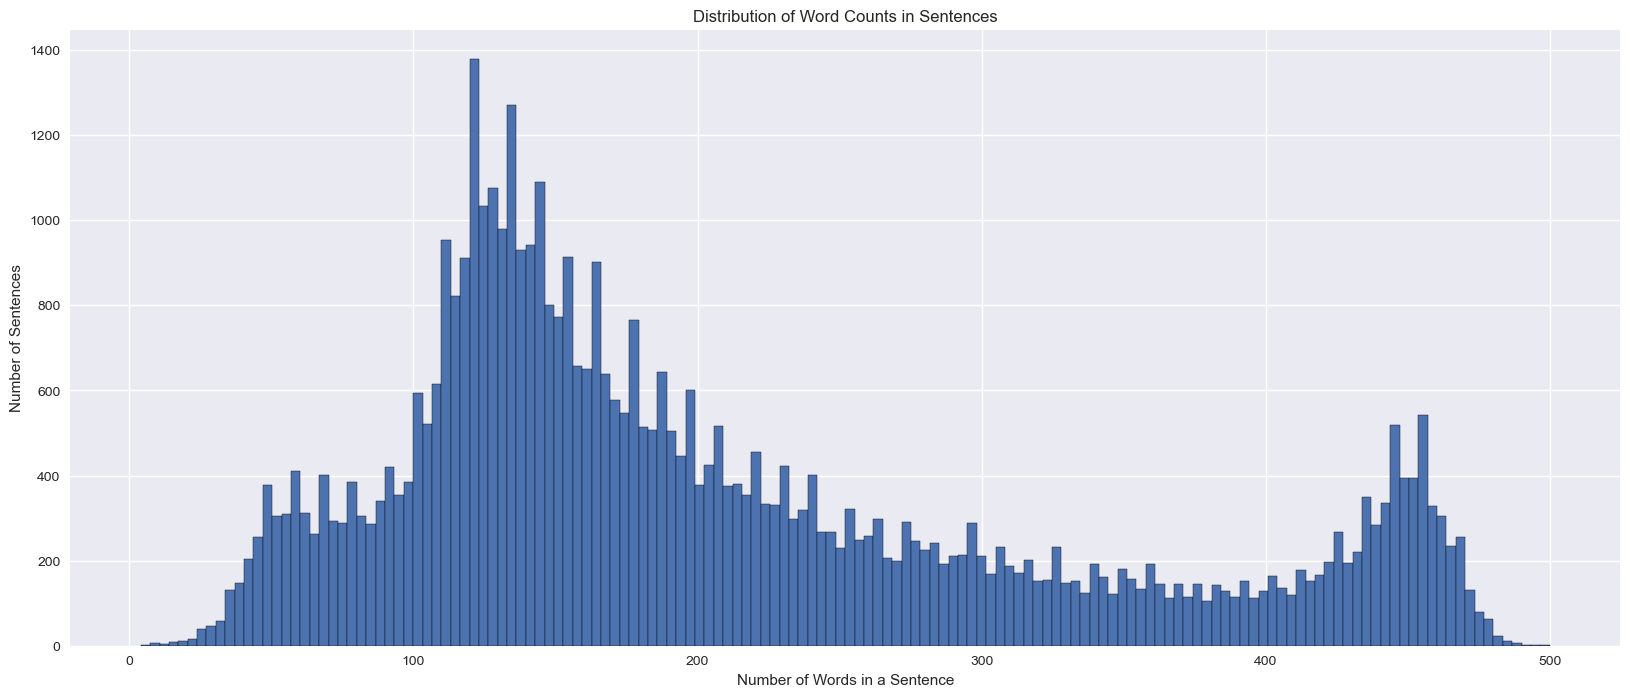

In [12]:
# Generate a histogram to group the data points
hist, bins = np.histogram(lengths, bins=150)

# Create the histogram plot
plt.figure(figsize=(20, 8))
plt.hist(lengths, bins=bins, edgecolor='k')
plt.xlabel('Number of Words in a Sentence')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Word Counts in Sentences')
plt.show()

#### Comparison with Huggingface's Version

In [13]:
from datasets import load_dataset

hugg_imdb = load_dataset("imdb")

In [14]:
df_hugg_imdb_train = hugg_imdb['train'].to_pandas()
df_hugg_imdb_test = hugg_imdb['test'].to_pandas()

print(df_hugg_imdb_train.shape, df_hugg_imdb_test.shape)

(25000, 2) (25000, 2)


In [15]:
display(pd.concat([df_hugg_imdb_train, df_hugg_imdb_test], axis=1))
display(df_imdb_clean)

,text,label,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I love sci-fi and am willing to put up with a ...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"Worth the entertainment value of a rental, esp...",0
2,If only to avoid making this type of film in t...,0,its a totally average film with a few semi-alr...,0
3,This film was probably inspired by Godard's Ma...,0,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"Oh, brother...after hearing about this ridicul...",0,"First off let me say, If you haven't enjoyed a...",0
...,...,...,...,...
24995,A hit at the time but now better categorised a...,1,Just got around to seeing Monster Man yesterda...,1
24996,I love this movie like no other. Another time ...,1,I got this as part of a competition prize. I w...,1
24997,This film and it's sequel Barry Mckenzie holds...,1,I got Monster Man in a box set of three films ...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1,"Five minutes in, i started to feel how naff th...",1


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,Petter Mattei's Love in the Time of Money is a...,positive
...,...,...
49992,I thought this movie did a down right good job...,positive
49993,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49994,I am a Catholic taught in parochial elementary...,negative
49995,I'm going to have to disagree with the previou...,negative


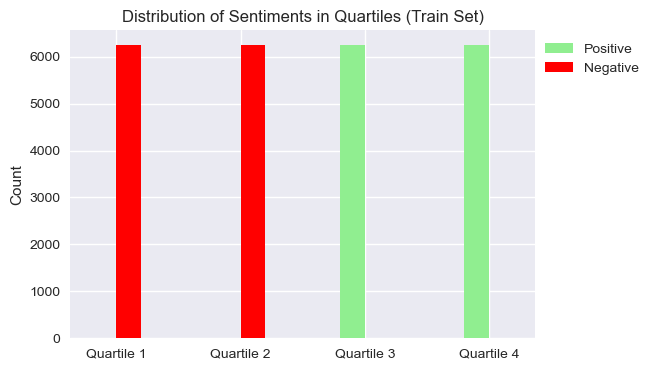

In [16]:
# Calculate the number of quartiles
num_quartiles = 4

# Calculate the number of samples in each quartile
quartile_size = len(df_hugg_imdb_train) // num_quartiles

# Initialize counters
positive_counts = []
negative_counts = []

# Iterate through each quartile
for i in range(num_quartiles):
    start_idx = i * quartile_size
    end_idx = (i + 1) * quartile_size

    quartile = df_hugg_imdb_train[start_idx:end_idx]
    
    positive_samples = len(quartile[quartile['label'] == 1])
    negative_samples = len(quartile[quartile['label'] == 0])
    
    positive_counts.append(positive_samples)
    negative_counts.append(negative_samples)

# Create a bar plot with specified dimensions
plt.figure(figsize=(6, 4))
quartile_labels = [f'Quartile {i+1}' for i in range(num_quartiles)]
width = 0.2
x = range(num_quartiles)

plt.bar(x, positive_counts, width, label='Positive', color='lightgreen')
plt.bar([i + width for i in x], negative_counts, width, label='Negative', color='red')

plt.ylabel('Count')
plt.title('Distribution of Sentiments in Quartiles (Train Set)')
plt.xticks([i + width / 2 for i in x], quartile_labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

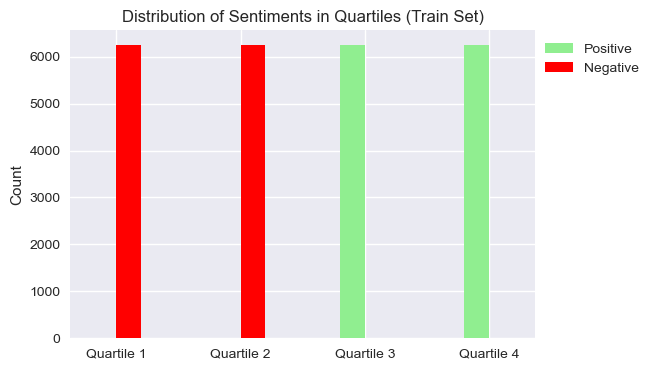

In [17]:
# Calculate the number of quartiles
num_quartiles = 4

# Calculate the number of samples in each quartile
quartile_size = len(df_hugg_imdb_test) // num_quartiles

# Initialize counters
positive_counts = []
negative_counts = []

# Iterate through each quartile
for i in range(num_quartiles):
    start_idx = i * quartile_size
    end_idx = (i + 1) * quartile_size

    quartile = df_hugg_imdb_test[start_idx:end_idx]
    
    positive_samples = len(quartile[quartile['label'] == 1])
    negative_samples = len(quartile[quartile['label'] == 0])
    
    positive_counts.append(positive_samples)
    negative_counts.append(negative_samples)

# Create a bar plot with specified dimensions
plt.figure(figsize=(6, 4))
quartile_labels = [f'Quartile {i+1}' for i in range(num_quartiles)]
width = 0.2
x = range(num_quartiles)

plt.bar(x, positive_counts, width, label='Positive', color='lightgreen')
plt.bar([i + width for i in x], negative_counts, width, label='Negative', color='red')

plt.ylabel('Count')
plt.title('Distribution of Sentiments in Quartiles (Train Set)')
plt.xticks([i + width / 2 for i in x], quartile_labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

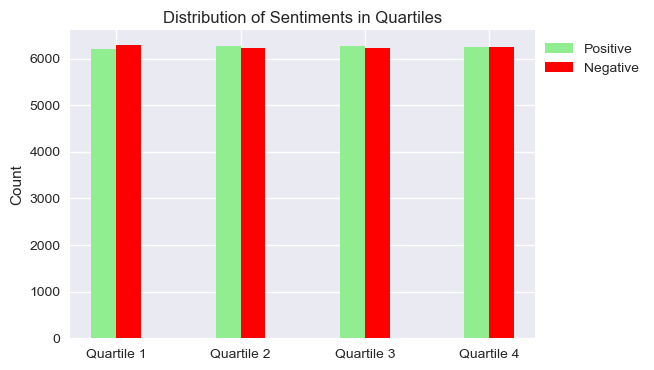

In [18]:
# Calculate the number of quartiles
num_quartiles = 4

# Calculate the number of samples in each quartile
quartile_size = len(df_imdb_clean) // num_quartiles

# Initialize counters
positive_counts = []
negative_counts = []

# Iterate through each quartile
for i in range(num_quartiles):
    start_idx = i * quartile_size
    end_idx = (i + 1) * quartile_size

    quartile = df_imdb_clean[start_idx:end_idx]
    
    positive_samples = len(quartile[quartile['sentiment'] == 'positive'])
    negative_samples = len(quartile[quartile['sentiment'] == 'negative'])
    
    positive_counts.append(positive_samples)
    negative_counts.append(negative_samples)

# Create a bar plot with specified dimensions
plt.figure(figsize=(6, 4))
quartile_labels = [f'Quartile {i+1}' for i in range(num_quartiles)]
width = 0.2
x = range(num_quartiles)

plt.bar(x, positive_counts, width, label='Positive', color='lightgreen')
plt.bar([i + width for i in x], negative_counts, width, label='Negative', color='red')

plt.ylabel('Count')
plt.title('Distribution of Sentiments in Quartiles')
plt.xticks([i + width / 2 for i in x], quartile_labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

#### Preprocessing

In [19]:
hugg_imdb_test_np = np.array(df_hugg_imdb_test)
hugg_imdb_test_np.shape

(25000, 2)

In [20]:
# Convert the dataset to numpy array
data_np = np.array(df_imdb_clean)
data_np.shape

(49997, 2)

### Hyperparameters

#### Orijinal

In [21]:
batch_size = 32
batch_size_cockatiel = 64

n_concepts = 20
n_reviews = 20000
n_excerpts = 50000
n_reviews_for_excerpts = 100000

positive_class = 1
negative_class = 0

output_names = ['negative', 'positive']
parent_path = "data/for_roberta/"

#### Huggingface Test

In [22]:
# batch_size = 64
# batch_size_cockatiel = 64

# n_concepts = 20
# #n_reviews = 20000
# n_excerpts = 50000
# n_reviews_for_excerpts = 100000

# positive_class = 1
# negative_class = 0

# output_names = ['negative', 'positive']
# parent_path = "data/huggingface_test/"

### Preparing RoBERTa Model

In [23]:
import torch

# Set up GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Selected component:", device)

Selected component: cuda


In [24]:
# Load the model and its tokenizer

from transformers import RobertaTokenizerFast
# from cockatiel import CustomRobertaForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
model = CustomRobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to(device)

# Put model into evaluation mode
model = model.eval()



# View model summary

import torchsummary as ts

print(ts.summary(model).total_params)



# # Make predictions on some samples
# y_pred, labels = batch_predict(model.forward, tokenizer, data_np[:1000], batch_size, device)

# # Compute the activations on which to apply the NMF
# features, labels = batch_predict(model.features, tokenizer, data_np[:1000], batch_size, device)

# # Go from these activations to the final prediction
# y_pred_bis = model.end_model(features)

# print("\nAccuracy for classic model        :", torch.mean((torch.argmax(y_pred, -1) == labels.to(device)).float()))
# print("Accuracy for model in 'two parts' :", torch.mean((torch.argmax(y_pred_bis, -1) == labels.to(device)).float()))

Layer (type:depth-idx)                        Param #
├─RobertaModel: 1-1                           --
|    └─RobertaEmbeddings: 2-1                 --
|    |    └─Embedding: 3-1                    38,603,520
|    |    └─Embedding: 3-2                    394,752
|    |    └─Embedding: 3-3                    768
|    |    └─LayerNorm: 3-4                    1,536
|    |    └─Dropout: 3-5                      --
|    └─RobertaEncoder: 2-2                    --
|    |    └─ModuleList: 3-6                   85,054,464
├─CustomRobertaClassificationHead: 1-2        --
|    └─Linear: 2-3                            590,592
|    └─Dropout: 2-4                           --
|    └─Linear: 2-5                            1,538
├─MSELoss: 1-3                                --
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
124647170


In [29]:
from sklearn.metrics import accuracy_score

def predict_evaluate(model, tokenizer, samples, device):
    
    r = np.array(list(map(lambda z: z[0], samples)))

    tokenized_samples = tokenize(r, tokenizer, device)

    preds = model(**tokenized_samples)

    # Extract texts and raw prediction scores
    texts = r
    raw_scores = preds.cpu().detach().numpy()

    # Apply softmax to get probabilities
    probabilities = torch.softmax(torch.tensor(raw_scores), dim=1)
    print(probabilities)
    positive_probabilities = probabilities[:, 'positive']  # Probability for the positive class
    negative_probabilities = probabilities[:, 'negative']  # Probability for the negative class

    # Extract predicted labels
    predictions = np.argmax(raw_scores, axis=1)

    # Calculate accuracy
    true_labels = samples[:, 1].astype(int)
    accuracy = accuracy_score(true_labels, predictions)

    data = {
        'Text': texts,
        'Predictions': predictions,
        'Positive Probability': positive_probabilities,
        'Negative Probability': negative_probabilities,
    }

    df = pd.DataFrame(data)
    display(df)
    
    print("Accuracy:", accuracy)
    
    return

In [31]:
predict_evaluate(model, tokenizer, data_np[:15], device)

tensor([[0.0264, 0.9736],
        [0.0180, 0.9820],
        [0.0218, 0.9782],
        [0.9862, 0.0138],
        [0.0215, 0.9785],
        [0.0177, 0.9823],
        [0.0622, 0.9378],
        [0.9886, 0.0114],
        [0.9901, 0.0099],
        [0.0196, 0.9804],
        [0.9596, 0.0404],
        [0.5649, 0.4351],
        [0.4100, 0.5900],
        [0.9541, 0.0459],
        [0.0234, 0.9766]])


TypeError: new(): invalid data type 'str'

### Objective 1: Reproducibility

#### Train COCKATIEL

In [27]:
# Veri kümesindeki ilk 20K'yı tahminletip kaydediyor

import pickle
from tqdm.notebook import tqdm

positive_reviews = []
negative_reviews = []

with torch.no_grad():
    for input_batch in tqdm(batcher(hugg_imdb_test_np, batch_size=batch_size), total=ceil(len(hugg_imdb_test_np) / batch_size)):
        
        r = np.array(list(map(lambda z: z[0], input_batch)))

        tokenized_batch = tokenize(r, tokenizer, device)
        
        preds = model(**tokenized_batch)
        
        positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
        negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

print(len(raw_dataset_pos), ' positive reviews predicted.')
print(len(raw_dataset_neg), ' negative reviews predicted.\n')

pickle.dump(raw_dataset_pos, open(parent_path + "raw_dataset_pos.pkl", "wb"))
pickle.dump(raw_dataset_neg, open(parent_path + "raw_dataset_neg.pkl", "wb"))


# Veriden excerpt'leri çıkarıyor

excerpt_dataset_pos = extract_excerpts(raw_dataset_pos, n_reviews_for_excerpts)
excerpt_dataset_neg = extract_excerpts(raw_dataset_neg, n_reviews_for_excerpts)

print(len(excerpt_dataset_pos), ' positive excerpts created.')
print(len(excerpt_dataset_neg), ' negative excerpts created.')

pickle.dump(excerpt_dataset_pos, open(parent_path + "excerpt_dataset_pos.pkl", "wb"))
pickle.dump(excerpt_dataset_neg, open(parent_path + "excerpt_dataset_neg.pkl", "wb"))

12796  positive reviews predicted.
12204  negative reviews predicted.



In [31]:
# Train COCKATIEL

from tqdm.notebook import tqdm

with torch.no_grad():
    
    cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components=n_concepts, 
                                        batch_size=batch_size_cockatiel, device=device)
    
    segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:n_excerpts], 
                                                                                                                      raw_dataset_pos[:(n_excerpts//10)], 
                                                                                                                      positive_class, 
                                                                                                                      limit_sobol=1_000)
    
pickle.dump(segments_pos, open(parent_path + "segments_pos.pkl", "wb"))
pickle.dump(u_segments_pos, open(parent_path + "u_segments_pos.pkl", "wb"))
pickle.dump(factorization_pos, open(parent_path + "factorization_pos.pkl", "wb"))
pickle.dump(global_importance_pos, open(parent_path + "global_importance_pos.pkl", "wb"))

with torch.no_grad():
    
    cockatiel_explainer_neg = COCKATIEL(model, tokenizer, components=n_concepts, 
                                        batch_size=batch_size_cockatiel, device=device)
    
    segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:n_excerpts], 
                                                                                                                      raw_dataset_neg[:(n_excerpts//10)], 
                                                                                                                      negative_class, 
                                                                                                                      limit_sobol=1_000)
    
pickle.dump(segments_neg, open(parent_path + "segments_neg.pkl", "wb"))
pickle.dump(u_segments_neg, open(parent_path + "u_segments_neg.pkl", "wb"))
pickle.dump(factorization_neg, open(parent_path + "factorization_neg.pkl", "wb"))
pickle.dump(global_importance_neg, open(parent_path + "global_importance_neg.pkl", "wb"))

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\onurp\anaconda3\envs\cockatiel\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


#### Load Files (No Train)

In [25]:
import pickle

# Load raw dataset and excerpts

raw_dataset_pos = pickle.load(open(parent_path + "raw_dataset_pos.pkl", "rb"))
raw_dataset_neg = pickle.load(open(parent_path + "raw_dataset_neg.pkl", "rb"))
excerpt_dataset_pos = pickle.load(open(parent_path + "excerpt_dataset_pos.pkl", "rb"))
excerpt_dataset_neg = pickle.load(open(parent_path + "excerpt_dataset_neg.pkl", "rb"))

# Load sentences and global importances for positive class

segments_pos = pickle.load(open(parent_path + "segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open(parent_path + "u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open(parent_path + "factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open(parent_path + "global_importance_pos.pkl",'rb'))

# Load sentences and global importances for negative class

segments_neg = pickle.load(open(parent_path + "segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open(parent_path + "u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open(parent_path + "factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open(parent_path + "global_importance_neg.pkl",'rb'))

#### Results (original)

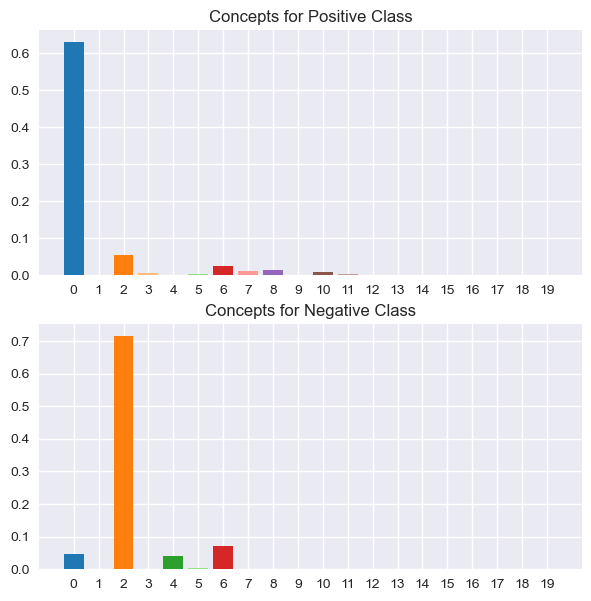

In [31]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [27]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




In [74]:
reviews_neg_text = [
    "I couldn't even follow the plot, but suffice it to say, this is the absolute worst movie I have ever seen in my life.",
    "This is by far one of the worst films I've ever paid good money to see.",
    'Words cannot begin to describe how blandly terrible this movie is.',
    "It's pointless.",
    'Plot is unimportant.',
    'About the only good thing about this is the setting.',
    "It's too bad because this film had great production values and a good cast, but isn't the idea of turning a book into a movie (TV or film) to get the people who read the book to be part of the audience."
]

reviews_neg = [[text, 'negative'] for text in reviews_neg_text]
reviews_neg = np.array(reviews_neg)

reviews_pos_text = [
    'One of the best movies ever, hands down.',
    'It is simply one of my all-time favorite films.',
    'Very inspiring and encouraging to all ages.',
    'The ballroom scenes were very nice, the dancing and the outfits looked beautiful.',
    "Billy Bitzer's camera work is quite good.",
    'The humor and sadness are subtly blended.',
    'Idrissa Oudraogo ( Burkina Faso ): from one of the poorest country in the world, a tender and funny story about five boys who want to capture Osama Bin Laden.',
    'Especially fun is the performance by Cronenberg as the truly evil human doctor who is bent on destroying the Nightbreed.'
]

reviews_pos = [[text, 'positive'] for text in reviews_pos_text]
reviews_pos = np.array(reviews_pos)

plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

#### Results (largest)

In [32]:
# import pickle

# # Load raw dataset and excerpts

# parent_path = "data/huggingface_test/"

# raw_dataset_pos = pickle.load(open(parent_path + "raw_dataset_pos.pkl", "rb"))
# raw_dataset_neg = pickle.load(open(parent_path + "raw_dataset_neg.pkl", "rb"))
# excerpt_dataset_pos = pickle.load(open(parent_path + "excerpt_dataset_pos.pkl", "rb"))
# excerpt_dataset_neg = pickle.load(open(parent_path + "excerpt_dataset_neg.pkl", "rb"))

# # Load sentences and global importances for positive class

# segments_pos = pickle.load(open(parent_path + "segments_pos.pkl",'rb'))
# u_segments_pos = pickle.load(open(parent_path + "u_segments_pos.pkl",'rb'))
# factorization_pos = pickle.load(open(parent_path + "factorization_pos.pkl",'rb'))
# global_importance_pos = pickle.load(open(parent_path + "global_importance_pos.pkl",'rb'))

# # Load sentences and global importances for negative class

# segments_neg = pickle.load(open(parent_path + "segments_neg.pkl",'rb'))
# u_segments_neg = pickle.load(open(parent_path + "u_segments_neg.pkl",'rb'))
# factorization_neg = pickle.load(open(parent_path + "factorization_neg.pkl",'rb'))
# global_importance_neg = pickle.load(open(parent_path + "global_importance_neg.pkl",'rb'))

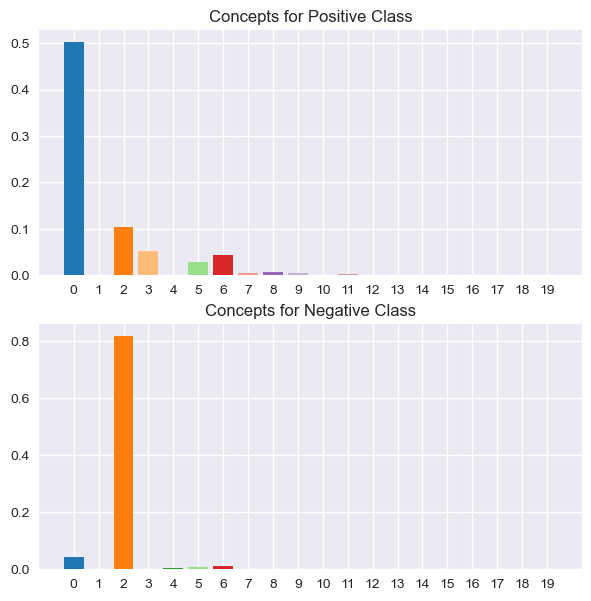

In [33]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [43]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:




In [44]:
reviews_neg_text = [
    "I couldn't even follow the plot, but suffice it to say, this is the absolute worst movie I have ever seen in my life.",
    "This is by far one of the worst films I've ever paid good money to see.",
    'Words cannot begin to describe how blandly terrible this movie is.',
    "It's pointless.",
    'Plot is unimportant.',
    'About the only good thing about this is the setting.',
    "It's too bad because this film had great production values and a good cast, but isn't the idea of turning a book into a movie (TV or film) to get the people who read the book to be part of the audience."
]

reviews_neg = [[text, 'negative'] for text in reviews_neg_text]
reviews_neg = np.array(reviews_neg)

reviews_pos_text = [
    'One of the best movies ever, hands down.',
    'It is simply one of my all-time favorite films.',
    'Very inspiring and encouraging to all ages.',
    'The ballroom scenes were very nice, the dancing and the outfits looked beautiful.',
    "Billy Bitzer's camera work is quite good.",
    'The humor and sadness are subtly blended.',
    'Idrissa Oudraogo ( Burkina Faso ): from one of the poorest country in the world, a tender and funny story about five boys who want to capture Osama Bin Laden.',
    'Especially fun is the performance by Cronenberg as the truly evil human doctor who is bent on destroying the Nightbreed.'
]

reviews_pos = [[text, 'positive'] for text in reviews_pos_text]
reviews_pos = np.array(reviews_pos)

plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

### Objective 2: Comparison with SHAP

In [47]:
import shap

def shap_explain(pipe, text, output_names):
    
    prediction = pipe([text])
    print(prediction[0])

    explainer = shap.Explainer(pipe, output_names=output_names)
    shap_values = explainer([text])

    shap.plots.text(shap_values)
    
    return None

In [80]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TextClassificationPipeline

tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
model = RobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to('cpu')

# Put model into evaluation mode
model = model.eval()

# Create a pipeline for sentiment analysis
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# Explain each sample in custom set
for sample in reviews_neg_text + reviews_pos_text:
    shap_explain(pipe, sample, output_names)

### Objective 3: Performance on Sarcasm

#### Results of Original Method

In [45]:
sarcasm_reviews_neg = [
    ["Wow, what a masterpiece! I can't believe I wasted two hours of my life on this.", 'negative'],
    ["Oh, great, another rom-com. Just what the world needed.", 'negative'],
    ["I've always wanted to watch a movie with endless plot holes. My dreams have come true!", 'negative'],
    ["This movie is a real game-changer. It changed the game of wasting my time.", 'negative']
]

sarcasm_reviews_pos = [
    ["Bravo, the director is a true genius. I couldn't understand a thing in the movie!", 'positive'],
    ["This movie is so bad, it's almost good. Almost.", 'positive'],
    ["Oscar-worthy performance by the lead actor... if the Oscars had a category for overacting.", 'positive'],
    ["I'm speechless. Literally. I lost the ability to speak during this cinematic marvel.", 'positive']
]

sarcasm_reviews_text_neg = [text[0] for text in sarcasm_reviews_neg]
sarcasm_reviews_text_pos = [text[0] for text in sarcasm_reviews_pos]

sarcasm_reviews_labels_neg = [text[1] for text in sarcasm_reviews_neg]
sarcasm_reviews_labels_pos = [text[1] for text in sarcasm_reviews_pos]

sarcasm_reviews = sarcasm_reviews_neg + sarcasm_reviews_pos

In [56]:
# from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TextClassificationPipeline
# from sklearn.metrics import accuracy_score

# tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
# model = RobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to('cpu')

# # Put model into evaluation mode
# model = model.eval()

# # Create a pipeline for sentiment analysis
# pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# # Get the predictions from the pipeline
# predictions = pipe(sarcasm_reviews_text_neg + sarcasm_reviews_text_pos)

# # Convert the predicted labels to numeric format
# predictions = [1 if label == 'LABEL_1' else 0 for label in predictions]

# # Convert the true labels to numeric format
# true_labels = sarcasm_reviews_labels_neg + sarcasm_reviews_labels_pos
# true_labels = [1 if label == 'positive' else 0 for label in true_labels]

# # Compute the accuracy
# accuracy = accuracy_score(true_labels, predictions)

# print("Accuracy of RoBERTa model on sarcastic samples:", accuracy)

Accuracy of RoBERTa model on sarcastic samples: 0.5


In [58]:
features, labels = batch_predict(model.features, tokenizer, np.array(sarcasm_reviews), batch_size, device)

y_pred = model.end_model(features)

print("Accuracy of custom RoBERTa model on sarcastic samples:", torch.mean((torch.argmax(y_pred, -1) == labels.to(device)).float()))

Accuracy of custom RoBERTa model on sarcastic samples: tensor(0.3750, device='cuda:0')


In [59]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[sarcasm_reviews_text_neg, sarcasm_reviews_text_pos])

#### Dataset

In [19]:
import ast

with open("data/sarcastic_samples_neg.txt", "r") as file:
    content = file.read()
    sarcastic_samples_neg = ast.literal_eval(content)

with open("data/sarcastic_samples_pos.txt", "r") as file:
    content = file.read()
    sarcastic_samples_pos = ast.literal_eval(content)

new_data_np = np.array(sarcastic_samples_neg + sarcastic_samples_pos)

#### Dataset Control (excluded)

In [70]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# import string

# def preprocess_data(text: str) -> str:
#     return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()

# tokenizer = AutoTokenizer.from_pretrained("helinivan/english-sarcasm-detector")
# model = AutoModelForSequenceClassification.from_pretrained("helinivan/english-sarcasm-detector")

C:\Users\onurp\anaconda3\envs\cockatiel\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\onurp\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [82]:
# sarcastic_samples = sarcastic_samples_neg + sarcastic_samples_pos

# for review in sarcastic_samples:
    
#     text = review[0]

#     tokenized_text = tokenizer([preprocess_data(text)], padding=True, truncation=True, max_length=256, return_tensors="pt")
#     output = model(**tokenized_text)

#     probs = output.logits.softmax(dim=-1).tolist()[0]
#     confidence = max(probs)

#     prediction = probs.index(confidence)
#     print(f"Is it sarcastic {prediction}, Confidence: {confidence}")

Is it sarcastic 0, Confidence: 0.7894307374954224
Is it sarcastic 0, Confidence: 0.9768994450569153
Is it sarcastic 0, Confidence: 0.8849927186965942
Is it sarcastic 0, Confidence: 0.9927780032157898
Is it sarcastic 0, Confidence: 0.9407753944396973
Is it sarcastic 0, Confidence: 0.7536627650260925
Is it sarcastic 0, Confidence: 0.993133544921875
Is it sarcastic 0, Confidence: 0.9858521223068237
Is it sarcastic 0, Confidence: 0.9944425225257874
Is it sarcastic 0, Confidence: 0.8262344598770142
Is it sarcastic 0, Confidence: 0.9960529804229736
Is it sarcastic 0, Confidence: 0.988563060760498
Is it sarcastic 0, Confidence: 0.9825398921966553
Is it sarcastic 0, Confidence: 0.9499245285987854
Is it sarcastic 0, Confidence: 0.99533611536026
Is it sarcastic 0, Confidence: 0.9950424432754517
Is it sarcastic 0, Confidence: 0.9919399619102478
Is it sarcastic 0, Confidence: 0.9935635328292847
Is it sarcastic 0, Confidence: 0.9713146090507507
Is it sarcastic 0, Confidence: 0.9960530996322632
Is i

#### Train COCKATIEL for Sarcasm

In [ ]:
# # Veri kümesindeki ilk 20K'yı tahminletip kaydediyor

# import pickle

# positive_reviews = []
# negative_reviews = []

# data_cockatiel = np.concatenate((data_np[:n_reviews], new_data_np))

# with torch.no_grad():
#     for input_batch in batcher(data_cockatiel, batch_size=batch_size):
        
#         r = np.array(list(map(lambda z: z[0], input_batch)))

#         tokenized_batch = tokenize(r, tokenizer, device)
        
#         preds = model(**tokenized_batch)
        
#         positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
#         negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

# raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
# raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

# pickle.dump(raw_dataset_pos, open(parent_path + "raw_dataset_pos.pkl", "wb"))
# pickle.dump(raw_dataset_neg, open(parent_path + "raw_dataset_neg.pkl", "wb"))

In [ ]:
# # Veriden excerpt'leri çıkarıyor
  
# excerpt_dataset_pos = extract_excerpts(raw_dataset_pos, n_reviews_for_excerpts)
# excerpt_dataset_neg = extract_excerpts(raw_dataset_neg, n_reviews_for_excerpts)

# print(len(excerpt_dataset_pos), ' positives excerpts created.')
# print(len(excerpt_dataset_neg), ' negatives excerpts created.')

# pickle.dump(excerpt_dataset_pos, open(parent_path + "excerpt_dataset_pos.pkl", "wb"))
# pickle.dump(excerpt_dataset_neg, open(parent_path + "excerpt_dataset_neg.pkl", "wb"))



# # Train COCKATIEL

# with torch.no_grad():
    
#     cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components=n_concepts, 
#                                         batch_size=batch_size_cockatiel, device=device)
    
#     segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:n_excerpts], 
#                                                                                                                       raw_dataset_pos[:(n_excerpts//10)], 
#                                                                                                                       positive_class, 
#                                                                                                                       limit_sobol=1_000)
    
# pickle.dump(segments_pos, open(parent_path + "segments_pos.pkl", "wb"))
# pickle.dump(u_segments_pos, open(parent_path + "u_segments_pos.pkl", "wb"))
# pickle.dump(factorization_pos, open(parent_path + "factorization_pos.pkl", "wb"))
# pickle.dump(global_importance_pos, open(parent_path + "global_importance_pos.pkl", "wb"))

# with torch.no_grad():
    
#     cockatiel_explainer_neg = COCKATIEL(model, tokenizer, components=n_concepts, 
#                                         batch_size=batch_size_cockatiel, device=device)
    
#     segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:n_excerpts], 
#                                                                                                                       raw_dataset_neg[:(n_excerpts//10)], 
#                                                                                                                       negative_class, 
#                                                                                                                       limit_sobol=1_000)
    
# pickle.dump(segments_neg, open(parent_path + "segments_neg.pkl", "wb"))
# pickle.dump(u_segments_neg, open(parent_path + "u_segments_neg.pkl", "wb"))
# pickle.dump(factorization_neg, open(parent_path + "factorization_neg.pkl", "wb"))
# pickle.dump(global_importance_neg, open(parent_path + "global_importance_neg.pkl", "wb"))

108322  positives excerpts created.
111440  negatives excerpts created.


In [21]:
import pickle

# Load raw dataset and excerpts

raw_dataset_pos = pickle.load(open(parent_path + "raw_dataset_pos.pkl", "rb"))
raw_dataset_neg = pickle.load(open(parent_path + "raw_dataset_neg.pkl", "rb"))
excerpt_dataset_pos = pickle.load(open(parent_path + "excerpt_dataset_pos.pkl", "rb"))
excerpt_dataset_neg = pickle.load(open(parent_path + "excerpt_dataset_neg.pkl", "rb"))

# Load sentences and global importances for positive class

segments_pos = pickle.load(open(parent_path + "segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open(parent_path + "u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open(parent_path + "factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open(parent_path + "global_importance_pos.pkl",'rb'))

# Load sentences and global importances for negative class

segments_neg = pickle.load(open(parent_path + "segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open(parent_path + "u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open(parent_path + "factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open(parent_path + "global_importance_neg.pkl",'rb'))

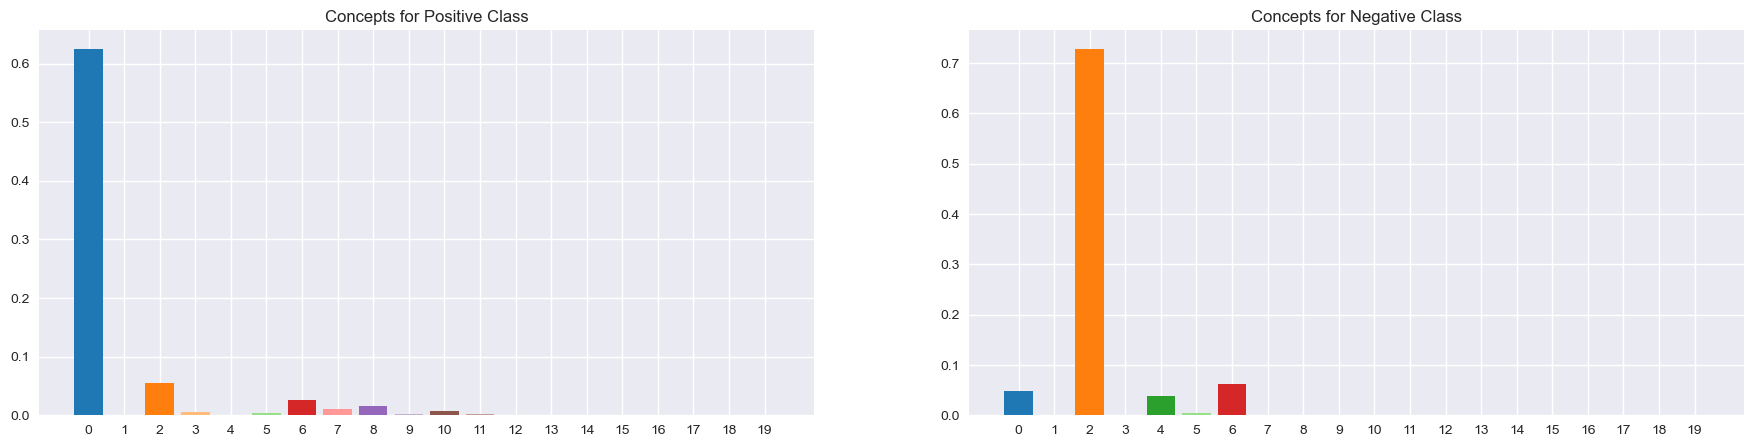

In [22]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [25]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[sarcasm_reviews_text_neg, sarcasm_reviews_text_pos])

# Workshop Area and Archive

### AlBERT

In [ ]:
# Load the model and its tokenizer

from transformers import AlbertTokenizerFast
from cockatiel import CustomAlbertForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = AlbertTokenizerFast.from_pretrained("Ibrahim-Alam/finetuning-albert-base-v2-on-imdb")
model = CustomAlbertForSequenceClassification.from_pretrained("Ibrahim-Alam/finetuning-albert-base-v2-on-imdb").to(device)

# Put model into evaluation mode
model = model.eval()



# View model summary

import torchsummary as ts

print(ts.summary(model).total_params)



# Make predictions on some samples
y_pred, labels = batch_predict(model.forward, tokenizer, data_np[:100], batch_size, device)

# Compute the activations on which to apply the NMF
features, labels = batch_predict(model.features, tokenizer, data_np[:100], batch_size, device)

# Go from these activations to the final prediction
y_pred_bis = model.end_model(features)

print("\nAccuracy for classic model        :", torch.mean((torch.argmax(y_pred, -1) == labels.to(device)).float()))
print("Accuracy for model in 'two parts' :", torch.mean((torch.argmax(y_pred_bis, -1) == labels.to(device)).float()))

#### Train COCKATIEL

In [ ]:
# # Veri kümesindeki ilk 20K'yı tahminletiyor

# positive_reviews = []
# negative_reviews = []

# with torch.no_grad():
#     for input_batch in batcher(data_np[:20000], batch_size=batch_size):
        
#         r = np.array(list(map(lambda z: z[0], input_batch)))

#         tokenized_batch = tokenize(r, tokenizer, device)
        
#         preds = model(**tokenized_batch)
        
#         positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
#         negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

# raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
# raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

# import pickle

# pickle.dump(raw_dataset_pos, open(parent_path + "raw_dataset_pos.pkl", "wb"))
# pickle.dump(raw_dataset_neg, open(parent_path + "raw_dataset_neg.pkl", "wb"))



# # Extract the excerpts as a dataset
  
# excerpt_dataset_pos = extract_excerpts(raw_dataset_pos)
# excerpt_dataset_neg = extract_excerpts(raw_dataset_neg)

# print(len(excerpt_dataset_pos), ' positives excerpts created.')
# print(len(excerpt_dataset_neg), ' negatives excerpts created.')

# pickle.dump(excerpt_dataset_pos, open(parent_path + "excerpt_dataset_pos.pkl", "wb"))
# pickle.dump(excerpt_dataset_neg, open(parent_path + "excerpt_dataset_neg.pkl", "wb"))



# # Train COCKATIEL

# with torch.no_grad():
    
#     cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components=20, 
#                                         batch_size=batch_size, device=device)
#     # batch size was 64 
#     segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:n_excerpts], 
#                                                                                                                       raw_dataset_pos[:(n_excerpts//10)], 
#                                                                                                                       1, limit_sobol=1_000)
    
# pickle.dump(segments_pos, open(parent_path + "segments_pos.pkl", "wb"))
# pickle.dump(u_segments_pos, open(parent_path + "u_segments_pos.pkl", "wb"))
# pickle.dump(factorization_pos, open(parent_path + "factorization_pos.pkl", "wb"))
# pickle.dump(global_importance_pos, open(parent_path + "global_importance_pos.pkl", "wb"))

# with torch.no_grad():
    
#     cockatiel_explainer_neg = COCKATIEL(model, tokenizer, components=20, 
#                                         batch_size=batch_size, device=device)
    
#     segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:n_excerpts], 
#                                                                                             raw_dataset_neg[:(n_excerpts//10)], 
#                                                                                             0, limit_sobol=1_000)
    
# pickle.dump(segments_neg, open(parent_path + "segments_neg.pkl", "wb"))
# pickle.dump(u_segments_neg, open(parent_path + "u_segments_neg.pkl", "wb"))
# pickle.dump(factorization_neg, open(parent_path + "factorization_neg.pkl", "wb"))
# pickle.dump(global_importance_neg, open(parent_path + "global_importance_neg.pkl", "wb"))

#### Run Directly

In [ ]:
import pickle

# Load raw dataset and excerpts

raw_dataset_pos = pickle.load(open(parent_path + "raw_dataset_pos.pkl", "rb"))
raw_dataset_neg = pickle.load(open(parent_path + "raw_dataset_neg.pkl", "rb"))
excerpt_dataset_pos = pickle.load(open(parent_path + "excerpt_dataset_pos.pkl", "rb"))
excerpt_dataset_neg = pickle.load(open(parent_path + "excerpt_dataset_neg.pkl", "rb"))

# Load sentences and global importances for positive class

segments_pos = pickle.load(open(parent_path + "segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open(parent_path + "u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open(parent_path + "factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open(parent_path + "global_importance_pos.pkl",'rb'))

# Load sentences and global importances for negative class

segments_neg = pickle.load(open(parent_path + "segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open(parent_path + "u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open(parent_path + "factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open(parent_path + "global_importance_neg.pkl",'rb'))

In [ ]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [ ]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

In [ ]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

### DistilBERT

In [ ]:
# Load the model and its tokenizer

from transformers import DistilBertTokenizerFast
from cockatiel import CustomDistilbertForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = DistilBertTokenizerFast.from_pretrained("federicopascual/finetuned-sentiment-analysis-model")
model = CustomDistilbertForSequenceClassification.from_pretrained("federicopascual/finetuned-sentiment-analysis-model").to(device)

# Put model into evaluation mode
model = model.eval()



# View model summary

import torchsummary as ts

print(ts.summary(model).total_params)



# Make predictions on some samples
y_pred, labels = batch_predict(model.forward, tokenizer, data_np[:100], batch_size, device)

# Compute the activations on which to apply the NMF
features, labels = batch_predict(model.features, tokenizer, data_np[:100], batch_size, device)

# Go from these activations to the final prediction
y_pred_bis = model.end_model(features)

print("\nAccuracy for classic model        :", torch.mean((torch.argmax(y_pred, -1) == labels.to(device)).float()))
print("Accuracy for model in 'two parts' :", torch.mean((torch.argmax(y_pred_bis, -1) == labels.to(device)).float()))

#### Train COCKATIEL

In [ ]:
# # Veri kümesindeki ilk 20K'yı tahminletiyor

# positive_reviews = []
# negative_reviews = []

# with torch.no_grad():
#     for input_batch in batcher(data_np[:20000], batch_size=batch_size):
        
#         r = np.array(list(map(lambda z: z[0], input_batch)))

#         tokenized_batch = tokenize(r, tokenizer, device)
        
#         preds = model(**tokenized_batch)
        
#         positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
#         negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

# raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
# raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

# import pickle

# pickle.dump(raw_dataset_pos, open(parent_path + "raw_dataset_pos.pkl", "wb"))
# pickle.dump(raw_dataset_neg, open(parent_path + "raw_dataset_neg.pkl", "wb"))



# # Extract the excerpts as a dataset
  
# excerpt_dataset_pos = extract_excerpts(raw_dataset_pos)
# excerpt_dataset_neg = extract_excerpts(raw_dataset_neg)

# print(len(excerpt_dataset_pos), ' positives excerpts created.')
# print(len(excerpt_dataset_neg), ' negatives excerpts created.')

# pickle.dump(excerpt_dataset_pos, open(parent_path + "excerpt_dataset_pos.pkl", "wb"))
# pickle.dump(excerpt_dataset_neg, open(parent_path + "excerpt_dataset_neg.pkl", "wb"))



# # Train COCKATIEL

# with torch.no_grad():
    
#     cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components=20, 
#                                         batch_size=batch_size, device=device)
#     # batch size was 64 
#     segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:n_excerpts], 
#                                                                                                                       raw_dataset_pos[:(n_excerpts//10)], 
#                                                                                                                       1, limit_sobol=1_000)
    
# pickle.dump(segments_pos, open(parent_path + "segments_pos.pkl", "wb"))
# pickle.dump(u_segments_pos, open(parent_path + "u_segments_pos.pkl", "wb"))
# pickle.dump(factorization_pos, open(parent_path + "factorization_pos.pkl", "wb"))
# pickle.dump(global_importance_pos, open(parent_path + "global_importance_pos.pkl", "wb"))

# with torch.no_grad():
    
#     cockatiel_explainer_neg = COCKATIEL(model, tokenizer, components=20, 
#                                         batch_size=batch_size, device=device)
    
#     segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:n_excerpts], 
#                                                                                             raw_dataset_neg[:(n_excerpts//10)], 
#                                                                                             0, limit_sobol=1_000)
    
# pickle.dump(segments_neg, open(parent_path + "segments_neg.pkl", "wb"))
# pickle.dump(u_segments_neg, open(parent_path + "u_segments_neg.pkl", "wb"))
# pickle.dump(factorization_neg, open(parent_path + "factorization_neg.pkl", "wb"))
# pickle.dump(global_importance_neg, open(parent_path + "global_importance_neg.pkl", "wb"))

#### Run Directly

In [ ]:
import pickle

# Load raw dataset and excerpts

raw_dataset_pos = pickle.load(open(parent_path + "raw_dataset_pos.pkl", "rb"))
raw_dataset_neg = pickle.load(open(parent_path + "raw_dataset_neg.pkl", "rb"))
excerpt_dataset_pos = pickle.load(open(parent_path + "excerpt_dataset_pos.pkl", "rb"))
excerpt_dataset_neg = pickle.load(open(parent_path + "excerpt_dataset_neg.pkl", "rb"))

# Load sentences and global importances for positive class

segments_pos = pickle.load(open(parent_path + "segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open(parent_path + "u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open(parent_path + "factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open(parent_path + "global_importance_pos.pkl",'rb'))

# Load sentences and global importances for negative class

segments_neg = pickle.load(open(parent_path + "segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open(parent_path + "u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open(parent_path + "factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open(parent_path + "global_importance_neg.pkl",'rb'))

In [ ]:
plot_glob_importances(global_importance_pos, global_importance_neg)

In [ ]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=False)

In [ ]:
plot_reviews_exp(segments_pos, u_segments_pos, factorization_pos, global_importance_pos,
                 segments_neg, u_segments_neg, factorization_neg, global_importance_neg,
                 custom_samples=True, samples_to_test=[reviews_neg, reviews_pos])

### Orinial Paper's Sentences

In [18]:
# ###### the killings are stupid and / or unimaginative bulamadım

# substring = "unimaginative"

# for index, string in enumerate(segments_neg):
#     if substring in string:
#         print(f"Substring '{substring}' found in string at index {index}: {string}")

In [19]:
# indices_neg = [35253, 29729, 35285, 14800, 14720, 31318, 15747]
# reviews_neg = np.array(segments_neg)[indices_neg]
# print(reviews_neg)

# indices_pos = [10108, 15711, 24157, 4142, 8211, 16541, 31384, 39364]
# reviews_pos = np.array(segments_pos)[indices_pos]
# print(reviews_pos)